# NBA Score Predictor

### Introduction
Many individuals enjoy watching sport games. For some, it is more fun to predict the outcomes of teams. Based on cameron measurements, can game scores be predicted for certain team matchups?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn import metrics
from sklearn import preprocessing #for standardization
from sklearn import linear_model

#Import datasets
NBAgames=pd.read_csv('../data/external/nba_elo.csv')

## Cleaning Data

#### Rows
Carmelo measurements started in 2015. Viewing the website associated with this dataset, it contains more information regarding the teams such as traveling and time between games. Since these measurements are relied on, all rows without this information must be dropped also elo columns are dropped.

#### Columns
Neutral does not make sense in this context as it contains 99% of zeroes as measured on Google Facets. Furthermore, viewing playoff, many empty values exist, so these two columns are dropped. Also, viewing date does not make much sense as these do not necessarily determine data playoffs which are cordinated in carmelo. Finally, probabilites are dropped as they are dependent on carmelo measurements.

In [2]:
#Dropping rows
NBAgames=NBAgames.dropna(subset=['carmelo1_pre'])

#Dropping columns
NBAgames=NBAgames.drop(columns=['neutral', 'playoff', 'date','elo1_pre','elo1_post','elo2_pre','elo2_post',])

## Transformation

After dropping unneccesary and unhelpful rows and columns, the index needs reset due to viewing the current few years. This creates an index column which is not needed. Lastly, all the cameron measurements and season need scaling(standardization) for machine learning algorithms.

For ease of running the kernel, the finalized dataset is saved to the internal data folder.

As a side note, I did attempt to normalize the scores, but fitting the dataset lead to errors.

In [3]:
#reset index
NBAgames=NBAgames.reset_index()
NBAgames=NBAgames.drop(columns=['index'])

#create hashes of team names and add to column
NBAgames['team1Hash']=NBAgames.team1.apply(hash)
NBAgames['team2Hash']=NBAgames.team2.apply(hash)

NBAgames['carmelo1_pre']=preprocessing.scale(NBAgames['carmelo1_pre'])
NBAgames['carmelo2_pre']=preprocessing.scale(NBAgames['carmelo2_pre'])
NBAgames['carmelo1_post']=preprocessing.scale(NBAgames['carmelo1_post'])
NBAgames['carmelo2_post']=preprocessing.scale(NBAgames['carmelo2_post'])


NBAgames['season']=NBAgames['season'].astype('float64')
NBAgames['season']=preprocessing.scale(NBAgames['season'])

#normalize scores
#mini=NBAgames['score1'].min()
#maxi=NBAgames['score1'].max()
#NBAgames['score1']=NBAgames['score1'].apply(lambda x: (x-mini)/(maxi-mini))

#mini=NBAgames['score2'].min()
#maxi=NBAgames['score2'].max()
#NBAgames['score2']=NBAgames['score2'].apply(lambda x: (x-mini)/(maxi-mini))

#save manipulated data to internal folder
NBAgames.to_csv('../data/internal/NBAval.csv')

## Modeling
In this assignment, regression models are created due to the numerical data. Based on this, random forests and logistic regression algorithms are implemented.

Before applying the modeling algorithms, labels and features require determining. Furthermore, the dataset also requires splitting into 80:10:10 for training, testing and validation.

In [4]:
#Grab the data
randomForest=pd.read_csv('../data/internal/NBAval.csv')
randomForest=randomForest.drop(columns=['Unnamed: 0'])

#Define the label to set
label=randomForest.loc[:,('score1', 'score2')]

#Define features
features=randomForest.drop(columns=['score1','score2','team1','team2'], axis=1)

#For plotting
feature_list=list(randomForest.columns)

#Convert to numpy array
features=np.array(features)

#Training/Testing/Validation Split
x, x_test, y, y_test = train_test_split(features,label,test_size=0.1,train_size=0.9)
x_train, x_val, y_train, y_val = train_test_split(x,y,test_size = 0.15,train_size =0.85)

#### Random Forest
The first model used is random forest. This model was previously used in the previous Shakespeare assignment. This collects the dataset and creates decisions based on the given values dependent on the labels.

Two phases follow below. First, random forests require training and fitting of the two training sets where one is the labels and the other is features. Second, the success of the model is determined with three measurements: mean squared error, mean squared log error, and explained variance scores. 

In [5]:
#----------Train---------
rf=RFC()

rf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [6]:
#--------Measuring Predictions and Errors----------
predictions=rf.predict(x_test)

#Determining success of random trees

sqLogErr=metrics.mean_squared_log_error(y_test,predictions)
sqErr=metrics.mean_squared_error(y_test,predictions)
variScore=metrics.explained_variance_score(y_test,predictions)
r2=metrics.r2_score(y_test,predictions)

print('Mean Squared Error:',sqErr)
print('Mean Squared Log Error: ',sqLogErr)
print('Explained Variance Score: ',variScore)
print('Variance score: ', r2)

#Test 1: Normalize
#249,0.0234,-0.562
#Test 2: Standardize
#248,0.0232,-0.443
#Test without probs and elo
#220,0.0211,-0.601
#Test without all probs
#229, 0.0216, -0.538
#Test with only elo
#249, 0.0228, -0.523
#Test with only elo all the way from the start
#347,0.03557,-0.4707
#Test with season and w/o probs and elo
#212.43, 0.0201, -0.404
#Test with normalizing team names
#260,0.0245,-0.71

#Final test without elo measurements and probabilities but did add season
#221.102,0.0207,-0.449

Mean Squared Error: 275.30583756345175
Mean Squared Log Error:  0.026485366151409617
Explained Variance Score:  -0.5871987955434986
Variance score:  -0.7342308977563808


#### Linear Regression
This algorithm attempts to determine labels through plotting lines. Similar to random forests, two phases follow: training and measurement. In contrast, R2 measurement is done which is a variance. The best score for that measurement is 1.0.


In [7]:
#Create and train
legr=linear_model.LinearRegression()

legr.fit(x_train, y_train)

#Make prediction
predictions=legr.predict(x_test)

In [8]:
mse=metrics.mean_squared_error(y_test, predictions)
sqLogErr=metrics.mean_squared_log_error(y_test,predictions)
variScore=metrics.explained_variance_score(y_test,predictions)
r2=metrics.r2_score(y_test,predictions)

print('Mean Squared Error:',mse)
print('Mean Squared Log Error: ',sqLogErr)
print('Explained Variance Score: ',variScore)
print('Variance Score: ',r2)

Mean Squared Error: 157.15605472368134
Mean Squared Log Error:  0.01459431237674868
Explained Variance Score:  0.009892370994220911
Variance Score:  0.009838072996063707


## Analysis
Random forests received a squared error of 232.57 where linear regression output 144.60. Viewing variance score, as previously stated, a value closer to 1.0 is better. Unfortunately, random forest scored -0.6075 and linear regression at 0.0094. This is incredibly low. This may be due to serveral different reasons. The main one is the type of data. This data is based on forecasting due to traveling, players and historic performance. By only using this as before and after games, it would be difficult to accurately determine the score. Another reason the models are ill-performing may be due to the score data. Would there be a difference if this numerical data was normalized? Unfortunately, trying to normalize throws an error. 

Viewing the below plot, one can see the means of the predicted scores are higher than the test samples. The histograms represent the test set and the lines represent the mean of the predicted set.

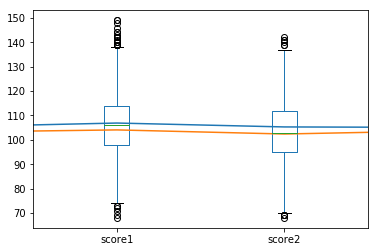

In [9]:
# Plot outputs
#plt.scatter(y_test, predictions, color='black')
#plt.plot(x_test, predictions, color='blue', linewidth=3)

#plot the actual scores
item=y_train.plot.box()
plt.plot(predictions)
#plot the predicted scores


## Conclusion
All in all, determining the scores based on the teams and carmelo measurements does not output useful results. By viewing both random forests and linear regression, the variance score is extremely low compared to 1 and the error is quite high. However, based on the above graph, the means of the test set and predicted set is not highly different (about 10 points).

## References
Helped with measuring success of regression
http://scikit-learn.org/stable/modules/classes.html#regression-metrics

Implement linear regression and measure
http://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html

### Normalization Previously Used
 
mini=NBAgames['elo1_pre'].min() 

maxi=NBAgames['elo1_pre'].max()

NBAgames['elo1_pre']=NBAgames['elo1_pre'].apply(lambda x: (x-mini)/(maxi-mini)) 

***
mini=NBAgames['elo2_pre'].min() 

maxi=NBAgames['elo2_pre'].max() 

NBAgames['elo2_pre']=NBAgames['elo2_pre'].apply(lambda x: (x-mini)/(maxi-mini)) 

***
mini=NBAgames['elo1_post'].min() 

maxi=NBAgames['elo1_post'].max() 

NBAgames['elo1_post']=NBAgames['elo1_post'].apply(lambda x: (x-mini)/(maxi-mini)) 
***
mini=NBAgames['elo2_post'].min() 

maxi=NBAgames['elo2_post'].max() 

NBAgames['elo2_post']=NBAgames['elo2_post'].apply(lambda x: (x-mini)/(maxi-mini)) 
***
mini=NBAgames['carmelo1_pre'].min() 

maxi=NBAgames['carmelo1_pre'].max() 

NBAgames['carmelo1_pre']=NBAgames['carmelo1_pre'].apply(lambda x: (x-mini)/(maxi-mini)) 
***
mini=NBAgames['carmelo2_pre'].min() 

maxi=NBAgames['carmelo2_pre'].max() 

NBAgames['carmelo2_pre']=NBAgames['carmelo2_pre'].apply(lambda x: (x-mini)/(maxi-mini)) 
***
mini=NBAgames['carmelo1_post'].min() 

maxi=NBAgames['carmelo1_post'].max() 

NBAgames['carmelo1_post']=NBAgames['carmelo1_post'].apply(lambda x: (x-mini)/(maxi-mini)) 
***
mini=NBAgames['carmelo2_post'].min() 

maxi=NBAgames['carmelo2_post'].max() 

NBAgames['carmelo2_post']=NBAgames['carmelo2_post'].apply(lambda x: (x-mini)/(maxi-mini)) 
